Импорты

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.morphology import binary_closing
from skimage import measure
from skimage.feature import canny
from skimage.measure import regionprops
from scipy import ndimage as ndi
from image_processing import check_for_place

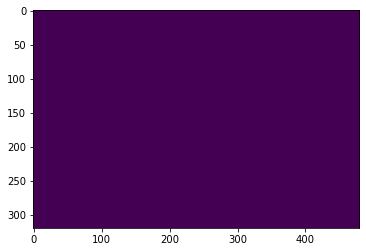

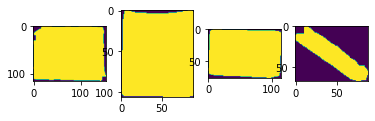

True


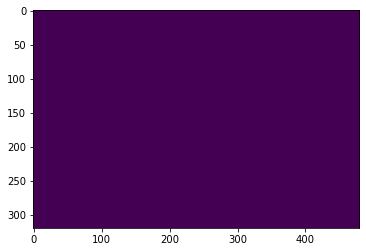

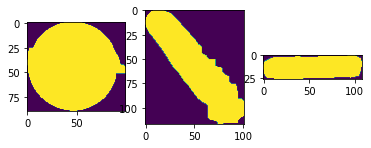

True


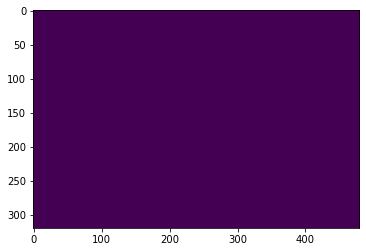

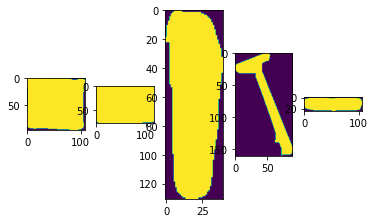

True


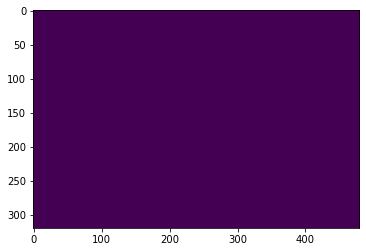

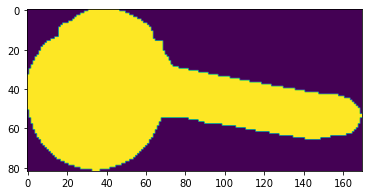

True


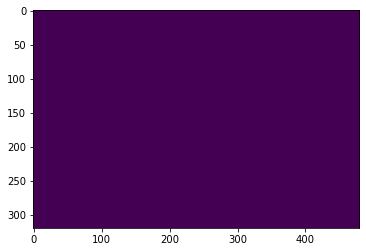

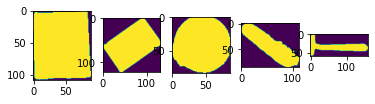

True


In [2]:
folder_path = "dataset"
check_for_place(folder_path)